In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
df_train.shape

(7613, 5)

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
df_train.fillna('Unknown', inplace=True)

In [8]:
df_train.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [9]:
columns = df_train.columns
columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [10]:
y_column = ['target']
x_columns = [c for c in columns if c not in y_column and c != 'id']
x_columns, y_column

(['keyword', 'location', 'text'], ['target'])

In [11]:
y = df_train[y_column].to_numpy()
X = df_train[x_columns].to_numpy()

In [12]:
X[:5]

array([['Unknown', 'Unknown',
        'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'],
       ['Unknown', 'Unknown', 'Forest fire near La Ronge Sask. Canada'],
       ['Unknown', 'Unknown',
        "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
       ['Unknown', 'Unknown',
        '13,000 people receive #wildfires evacuation orders in California '],
       ['Unknown', 'Unknown',
        'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']],
      dtype=object)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

In [14]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6090, 3), (1523, 3), (6090, 1), (1523, 1))

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-04-09 06:13:29.661654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 06:13:29.661786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 06:13:29.821616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
hyperparameters = {
'vocab_size': 10000,
'trun_type': 'post',
'padding_type': 'post',
'embed_dim': 16,
'maxlen': 32}

In [17]:
tokenizer = Tokenizer(oov_token='<OOV>', num_words=hyperparameters['vocab_size'])


In [18]:
def get_data(X):
    sentences = X[:, -1]
    locations = X[:, 1]
    keywords = X[:, 0]
    return sentences, locations, keywords

In [19]:
def text_to_seq(tokenizer, texts, hp, is_main_seq=False):
    seq = tokenizer.texts_to_sequences(texts)
    if is_main_seq:
        padded = pad_sequences(seq, padding=hp['padding_type'],truncating=hp['trun_type'], maxlen=22)
    else:
        padded = pad_sequences(seq, padding=hp['padding_type'],truncating=hp['trun_type'], maxlen=8)
    return padded

In [20]:
def preproc_seq(ms, ls, ks, hp):
    seq = []
    for m, l, k in zip(ms, ls, ks):
        seq.append(m.tolist() + l.tolist() + k.tolist())
    return pad_sequences(seq, maxlen=hp['maxlen'], padding=hp['padding_type'],truncating=hp['trun_type'])

In [21]:
def prepare_data(X_train, X_val, tokenizer, hyperparameters):
    sen, loc, key = get_data(X_train)
    tokenizer.fit_on_texts(sen + loc + key)
    
    finals_seq = []
    
    for x in (X_train, X_val):
        sen, loc, key = get_data(x)
        padded_main_seq = text_to_seq(tokenizer, sen, hyperparameters, is_main_seq=True)
        padded_loc_seq = text_to_seq(tokenizer, loc, hyperparameters)
        padded_key_seq = text_to_seq(tokenizer, key, hyperparameters)
        finals_seq.append(preproc_seq(padded_main_seq, padded_loc_seq, padded_key_seq, hyperparameters))
    
    
    return finals_seq[0], finals_seq[1]

In [22]:
train_seq, val_seq = prepare_data(X_train, X_val, tokenizer, hyperparameters)

In [23]:
train_seq.shape

(6090, 32)

In [24]:
val_seq.shape

(1523, 32)

In [25]:
import tensorflow as tf
def create_model(hyper):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(hyper['vocab_size'], hyper['embed_dim'], input_shape=(hyper['maxlen'], )),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [26]:
model = create_model(hyperparameters)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,817 (698.50 KB)

 Trainable params: 178,817 (698.50 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(
    train_seq,
    y_train,
    epochs=15,
    validation_data=(val_seq, y_val)
)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9701 - loss: 0.0720 - val_accuracy: 0.7722 - val_loss: 2.4543
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9782 - loss: 0.0533 - val_accuracy: 0.7754 - val_loss: 2.6772
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9781 - loss: 0.0535 - val_accuracy: 0.7643 - val_loss: 2.3250
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9783 - loss: 0.0625 - val_accuracy: 0.7676 - val_loss: 3.0259
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9711 - loss: 0.0716 - val_accuracy: 0.7715 - val_loss: 2.3102
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9761 - loss: 0.0647 - val_accuracy: 0.7656 - val_loss: 2.4060
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9805 - loss: 0.0488 - val_accuracy: 0.7702 - val_loss: 2.4597
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9831 - loss: 0.0438 - val_accu

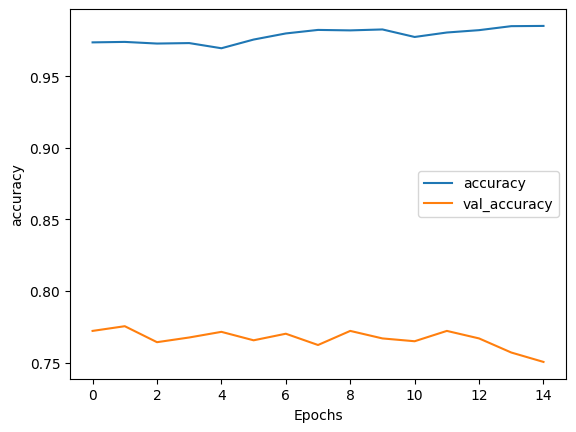

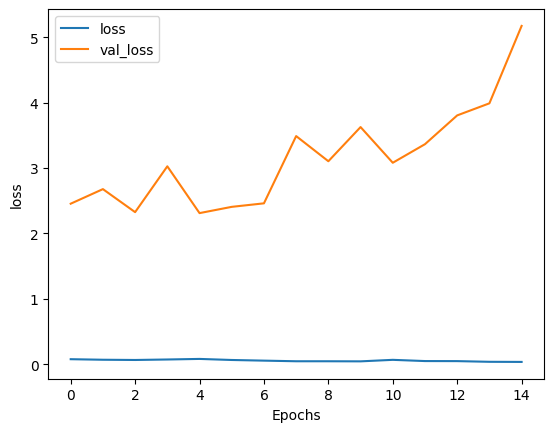

In [43]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [44]:
predictions_val = model.evaluate(val_seq, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7460 - loss: 5.3389


In [45]:
predictions_val

[5.17356538772583, 0.7504924535751343]

In [46]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [47]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [48]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [49]:
df_test.shape

(3263, 4)

In [50]:
df_test.fillna('Unknown', inplace=True)

In [51]:
df_test.isna().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

In [52]:
X_test = df_test[x_columns].to_numpy()
X_test[:3]

array([['Unknown', 'Unknown', 'Just happened a terrible car crash'],
       ['Unknown', 'Unknown',
        'Heard about #earthquake is different cities, stay safe everyone.'],
       ['Unknown', 'Unknown',
        'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all']],
      dtype=object)

In [53]:
def prepare_test_data(X, tokenizer, hyperparameters):
    sen, loc, key = get_data(X)
    padded_main_seq = text_to_seq(tokenizer, sen, hyperparameters, is_main_seq=True)
    padded_loc_seq = text_to_seq(tokenizer, loc, hyperparameters)
    padded_key_seq = text_to_seq(tokenizer, key, hyperparameters)
    return preproc_seq(padded_main_seq, padded_loc_seq, padded_key_seq, hyperparameters)
    
 

In [54]:
test_seq = prepare_test_data(X_test, tokenizer, hyperparameters)
test_seq.shape

(3263, 32)

In [55]:
test_seq[:3]

array([[  33,  973,    6, 2133,  145,   89,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        3354,    0,    0,    0,    0,    0,    0,    0, 3354,    0],
       [ 483,   57,  315,   12, 1276, 3885,  600, 2454,  281,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        3354,    0,    0,    0,    0,    0,    0,    0, 3354,    0],
       [  78,   12,    6,  206,   46,   20,  856, 3658,    1,   26, 5080,
         835,    5,  885,   11, 1465,  556,  108,   41,    0,    0,    0,
        3354,    0,    0,    0,    0,    0,    0,    0, 3354,    0]],
      dtype=int32)

In [70]:
predictions = model.predict(test_seq)
predictions[:5]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[0.04220341],
       [0.99994594],
       [1.        ],
       [0.99999744],
       [1.        ]], dtype=float32)

In [71]:
for i in range(len(predictions)):
    predictions[i, 0] = 1 if predictions[i, 0] > 0.5 else 0

In [73]:
ids = df_test['id'].to_numpy()

In [74]:
ids

array([    0,     2,     3, ..., 10868, 10874, 10875])

In [87]:
result = pd.DataFrame({'id': ids, 'target': pred[:, 0]})

In [88]:
result.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [89]:
result.set_index('id', inplace=True)
result.head()

,target
id,
0,0
2,1
3,1
9,1
11,1


In [90]:
result.to_csv('/kaggle/working/submission.csv')